In [17]:
from google.colab import files
uploaded = files.upload()

Saving pima-indians-diabetes.csv to pima-indians-diabetes.csv


In [3]:
import pandas as pd
import numpy as np
from numpy.random import rand

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # missingno package is helpful for visualizing the missingness.
from scipy.stats import linregress
from empiricaldist import Pmf, Cdf 

%matplotlib inline

In [18]:
data=pd.read_csv("pima-indians-diabetes.csv")
data.head()

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
0,6.0,148.0,72.0,35.0,NaN,33.6,0.627,50,1.0
1,1.0,85.0,66.0,29.0,NaN,26.6,0.351,31,0.0
2,8.0,183.0,64.0,NaN,NaN,23.3,0.672,32,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1.0


##### For better consistency, Rename ***Diastolic_BP*** to ***BP***, ***Skin_Fold*** to ***skin***, ***Serum_Insulin*** to ***insulin*** and ***Diabetes_Pedigree*** to ***DPF***. 

In [19]:
data=data.rename(columns ={ "Diastolic_BP": "BP", 
                           "Skin_Fold":"skin", 
                           "Serum_Insulin":"insulin", 
                           "Diabetes_Pedigree": "DPF",})

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pregnant  768 non-null    float64
 1   Glucose   763 non-null    float64
 2   BP        733 non-null    float64
 3   skin      541 non-null    float64
 4   insulin   394 non-null    float64
 5   BMI       757 non-null    float64
 6   DPF       768 non-null    float64
 7   Age       768 non-null    int64  
 8   Class     768 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


We have 768 entries, one row for each sample that is prone to be diabetic.
We have alot of missingness

In [21]:
data["Class"].value_counts()

0.0    500
1.0    268
Name: Class, dtype: int64

##### The largest proportion of samples are ***not diabetic***. But for better eye view, let's visaulize it.
But first lest's set global style for all graphs.

In [22]:
sns.set(font_scale=1.5, rc={"figure.figsize":(8,6)})
sns.set_style("ticks")

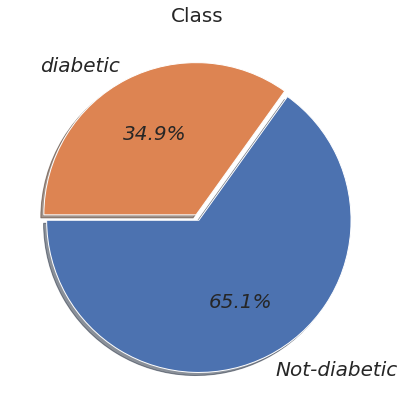

In [23]:
pie=data["Class"].value_counts()
plt.figure(figsize=(7,7))

plt.pie(pie, labels=["Not-diabetic", "diabetic"],
        explode=[0.02,0.02],
        startangle=180,
        autopct='%1.1f%%',shadow=True, 
        textprops={"fontsize":20, "style":"italic"})

plt.title('Class', fontsize=20)
plt.show()

# ***Data cleaning***.

In [24]:
data.isna().sum()

Pregnant      0
Glucose       5
BP           35
skin        227
insulin     374
BMI          11
DPF           0
Age           0
Class         0
dtype: int64

#### we can observe that there are alot of missingness in Glucose, BloodPressure, SkinThickness and BMI.

In [44]:
nulity_data = data.isnull() #extract missingness
print("The percentage of missingness per column \n")
nulity_data= round(nulity_data.mean() * 100, 2)
pd.DataFrame(nulity_data)

The percentage of missingness per column 



,0
Pregnant,0.00
Glucose,0.65
BP,4.56
skin,29.56
insulin,48.70
BMI,1.43
DPF,0.00
Age,0.00
Class,0.00


for better eye view, let's visualize ***the percentage and distribution of missingness*** in our dataset

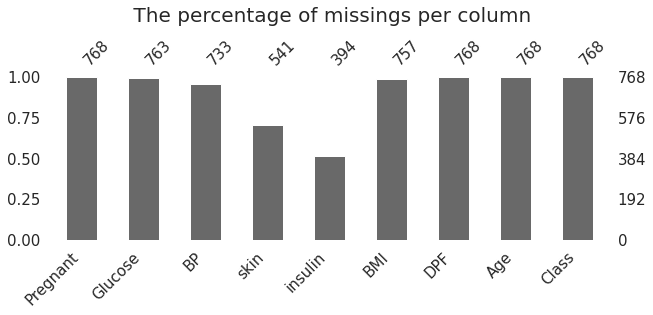

In [27]:
msno.bar(data, figsize=(10,3), fontsize=15)
plt.title(" The percentage of missings per column", y=1.3, fontsize=20)
plt.show()

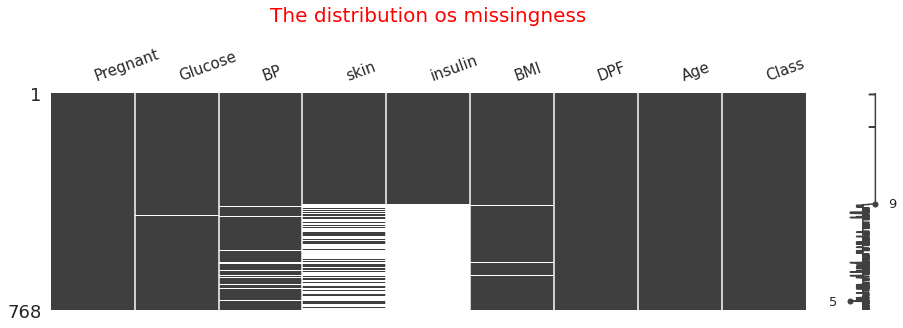

In [33]:
sorted_data = data.sort_values(by="insulin") # sort our dataset by the serumn_insulin 

msno.matrix(sorted_data, figsize=(15,4), fontsize=15)
plt.title("The distribution os missingness", y=1.3, fontsize=20, color="red")
plt.xticks(rotation=20)
plt.show()

##### Intersting, we can observe that missingness in SkinThickness is ***Missing Not at Random***. Let's dig deeper and find out more about missingness.

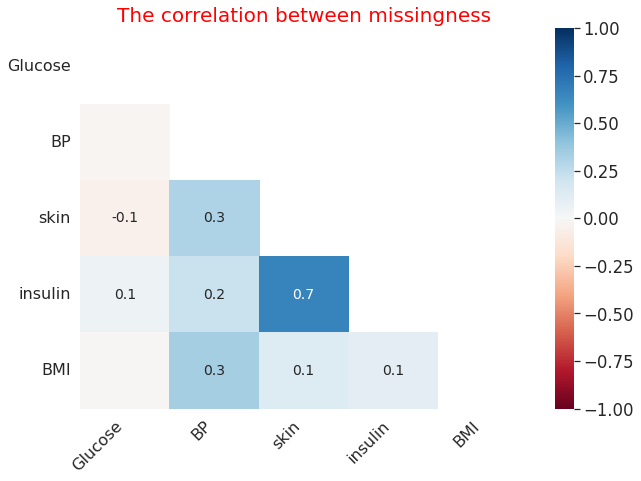

In [30]:
msno.heatmap(data, figsize=(10,7))
plt.title("The correlation between missingness", fontsize=20, color="red")
plt.show()

**Nullity correlation** ranges from -1 to 1, where -1 means if one variable appears the other definitely does not, 0 means if variables appearing or not appearing have no effect on one another, 1 means if one variable appears the other definitely also does.
As we can see there's a strong relation between missingnes in Skin_fold and serum_Insulin.

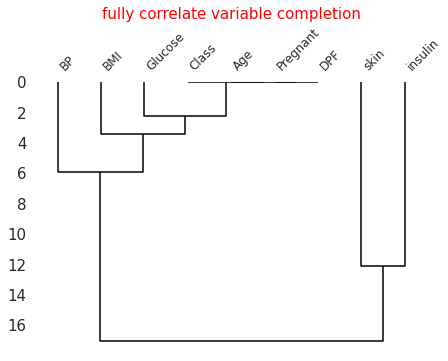

In [34]:
msno.dendrogram(data, figsize=(7,5), fontsize=12)
plt.title("fully correlate variable completion", fontsize=15, color="red")
plt.show()

To interpret this graph, read it from a top-to-down perspective. Cluster leaves which are linked together at a distance of zero.
Skin Fold' and 'Serum Insulin' are highly correlated which is also clear from ***the heatmap graph***, and can be mentioned as ***Missing Not at Random***. 
The missingness of 'Glucose' appears to be similar to 'BMI' than to 'Diastolic_BP'. However, checking its matrix plot and the number of values only confirms the fact of  their correlation is high only because both 'BMI' and 'Glucose' in specific have very few missing values. Hence, 'Glucose' can as well be considered as Missing Completely at Random.

In [35]:
def fill_dummy(df, scaling_factor=0.075):
  df_dummy = df.copy(deep=True)
  for col_name in df_dummy:
    col = df_dummy[col_name]
    col_null = col.isnull()    
    # Calculate number of missing values in column 
    num_nulls = col_null.sum()
    # Calculate column range
    col_range = col.max() - col.min()
    # Scale the random values to scaling_factor times col_range
    dummy_values = (rand(num_nulls) - 2) * scaling_factor * col_range + col.min()
    col[col_null] = dummy_values
  return df_dummy

In [38]:
# Fill dummy values in diabetes_dummy
diabetes_dummy = fill_dummy(data)

# Sum the nullity of Skin_Fold and BMI
nullity = data['skin'].isnull()+data['insulin'].isnull()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


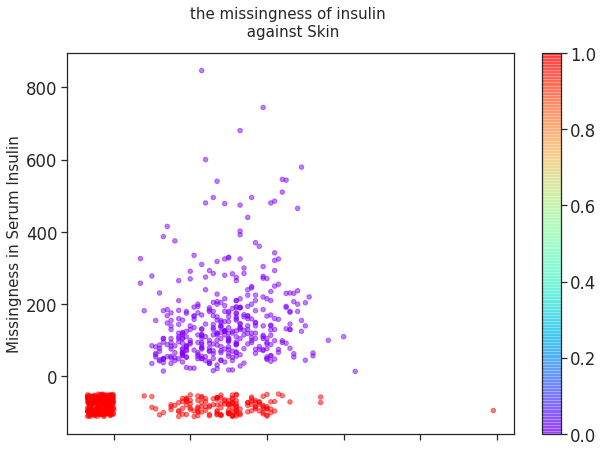

In [45]:
# Create a scatter plot of Skin Fold and BMI 
diabetes_dummy.plot(x='skin', y='insulin', kind='scatter', alpha=0.5,
                    # Set color to nullity of BMI and Skin_Fold
                    c=nullity, cmap='rainbow', figsize=(10,7))
plt.title("the missingness of insulin \n against Skin", y=1.03, fontsize=15)
plt.ylabel("Missingness in Serum Insulin", fontsize=15)
plt.show()

#### The scatterplot of ***Serum_Insulin*** and ***skin*** illustrated above shows the ***non-missing values in purple*** and the ***missing values in red***. The red points along the y-axis are the missing values of 'Serum_Insulin' plotted against their 'skin' values. Likewise, the points along the x-axis are the missing values of ***'skin'*** against their ***'Insulin'*** values. The bottom-left corner represents the missing values of both 'skin' and 'Serum_Insulin'. 

### ***Imputing missingness***.
The ***KNN imputation technique*** uses the K-Nearest Neighbor algorithm for predicting the missing values, finding the most similar data points using all the non-missing features for a data point and calculates the average of these similar points to fill the missing feature. Here, K specifies the number of similar or nearest points to consider. 

In [41]:
# Impute missingness with KNN
from sklearn.impute import KNNImputer
# Copy diabetes to diabetes_knn_imputed
cleandataK = data.copy(deep=True)

# Initialize KNN
knn_imputer = KNNImputer()
# Impute using fit_tranform on diabetes_knn_imputed
cleandataK.iloc[:, :] = knn_imputer.fit_transform(cleandataK)

***The MICE imputation*** is a very robust and ***complex model*** for imputing missing values. It imputes using ***multiple regressions*** over the data and takes the ***average*** value for filling in the missing feature for a data point.

In [42]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

# Copy diabetes to diabetes_mice_imputed
cleandataM = data.copy(deep=True)
mice_imputer = IterativeImputer() # Initialize IterativeImputer
# Impute using fit_tranform on diabetes
cleandataM.iloc[:, :] = mice_imputer.fit_transform(cleandataM)

A good way to analyze the ***performance*** of different ***imputations*** is to observe their ***density plots*** and see which one most resembles the shape of the original data. 

In [ ]:
#Let's make a baseline model, to compare ather imputations throw density plots by dropping missingness.
diabetes_cc = data.dropna(how='any')

#### Now, Let's get Comparing density plots to evaluate imputations.

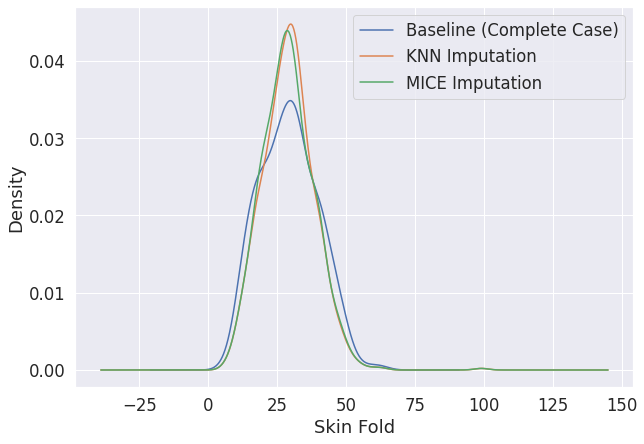

In [ ]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10,7))

diabetes_cc["Skin_Fold"].plot(kind="kde")
cleandataK["Skin_Fold"].plot(kind="kde")
cleandataM["Skin_Fold"].plot(kind="kde")

labels = ['Baseline (Complete Case)', 'KNN Imputation', 'MICE Imputation']
plt.legend(labels)
plt.xlabel('Skin Fold')
plt.show()

The KNN and MICE imputations are much more identical to the base DataFrame with the peak of MICE imputation being slightly shifted!
So, better to use KNN imputation.

###### Let's check for duplicates.
using ***duplicated()*** method ***without parameters*** leands to ***missleading results*** . So, we're going to use subset parameter and pass columns to it, to chech if there any duplicates through this columns to get ***complete duplicates*** and     
***duplicates with discrepencies*** .

In [ ]:
duplicates = cleandataK.duplicated(subset=["Glucose", "Diastolic_BP", "BMI", "Age", "Class"], keep=False)
cleandataK[duplicates]

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class


It seems that there is no duplicates in our dataset 

### ***Exploration and analysis***.

#### statistical summary

In [ ]:
newdata = cleandataK.copy(deep=True)
newdata.describe()

,Pregnant,Glucose,BP,skin,insulin,BMI,DPF,Age,Class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.598177,72.371354,29.114583,153.180208,32.427344,0.471876,33.240885,0.348958
std,3.369578,30.496543,12.206417,9.424100,98.385308,6.886588,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,23.000000,87.900000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,133.700000,32.090000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,35.000000,190.150000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### from summary statistics. the min of Age is 21 and mean is 33, the first quartile of our sample age is between 21 and 24. But for better eye view let's display boxplot

##### let's collapse Age into few categories

In [ ]:
testAge = newdata.copy()
ranges=[21,30,40,50,60,np.inf]
labels=["21-30","30-40","40-50","50-60","60+"]
testAge["Age"]=pd.cut(testAge["Age"],labels=labels, bins=ranges)

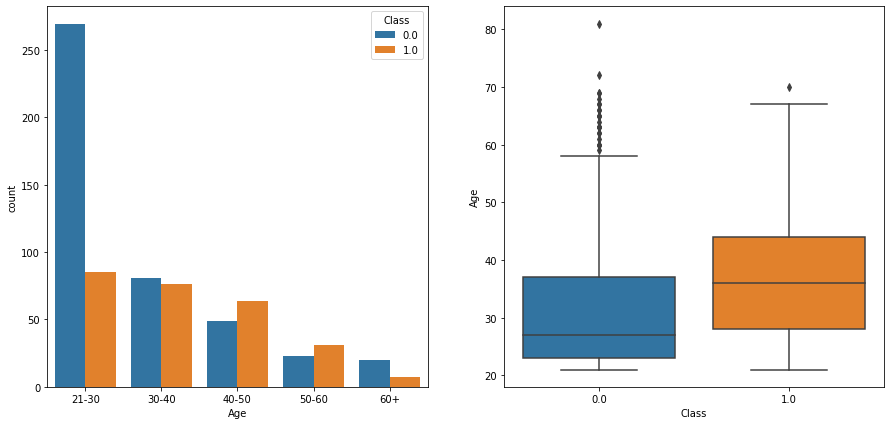

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
sns.countplot(data=testAge, x="Age", hue="Class")

plt.subplot(1,2,2)
sns.boxplot(x=newdata["Class"], y=data["Age"])

plt.show()

### Through this ***right-skewed distribution***, we can observe that ***just the person's age*** is not a ***good indicator of diabetes***, but we can say that ***young people from 21-to-30 have a lower chance of being diabestic*** and people in 40th have a heigher chance to be diabetic.

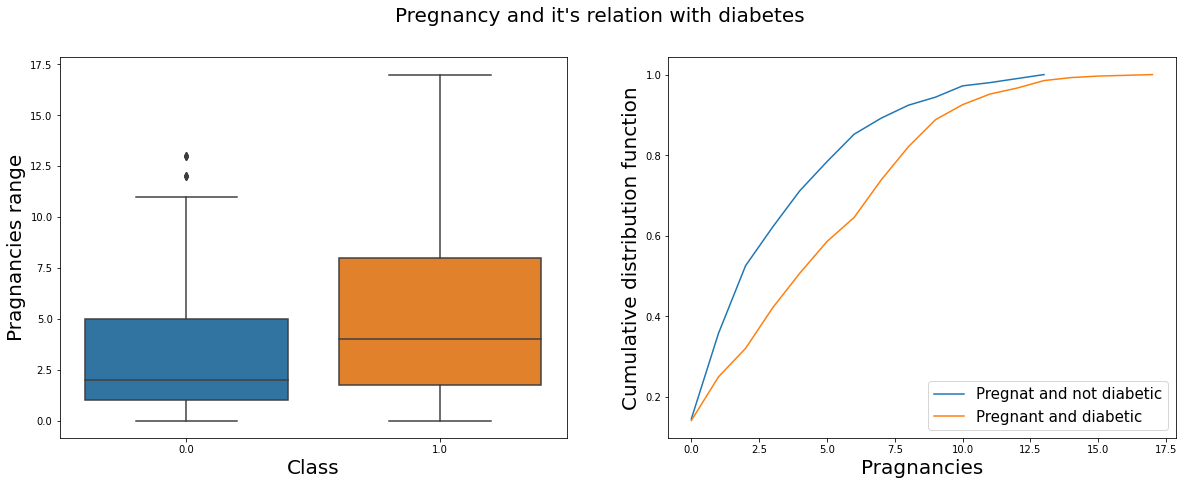

In [ ]:
dia = newdata[newdata["Class"] == 1]
notdia = newdata[newdata["Class"] == 0]
fig,ax =plt.subplots(1,2, figsize=(15,7))
fig.suptitle("Pregnancy and it's relation with diabetes", fontsize=20)

plt.subplot(1,2,1)
sns.boxplot(data=newdata, x="Class", y="Pregnant")
plt.ylabel("Pragnancies range", fontsize=20)
plt.xlabel("Class", fontsize=20)

plt.subplot(1,2,2)
Cdf.from_seq(notdia["Pregnant"], normalize=True).plot(label= "Pregnat and not diabetic")
Cdf.from_seq(dia["Pregnant"], normalize=True).plot(label= "Pregnant and diabetic")
plt.xlabel("Pragnancies", fontsize=20)
plt.ylabel("Cumulative distribution function", fontsize=20)
plt.legend(fontsize=15)
plt.show()

##### As we can observe, Over pragnancies have diabeties.
##### All females who are not diabetic have been pragnant less than 11 times, and there're tow samples are outlier.
##### 75% of females that's not diabetic have been pregnant less than 5 times
##### 75% of females  that's diabetic have been pregnant less than 8 times.

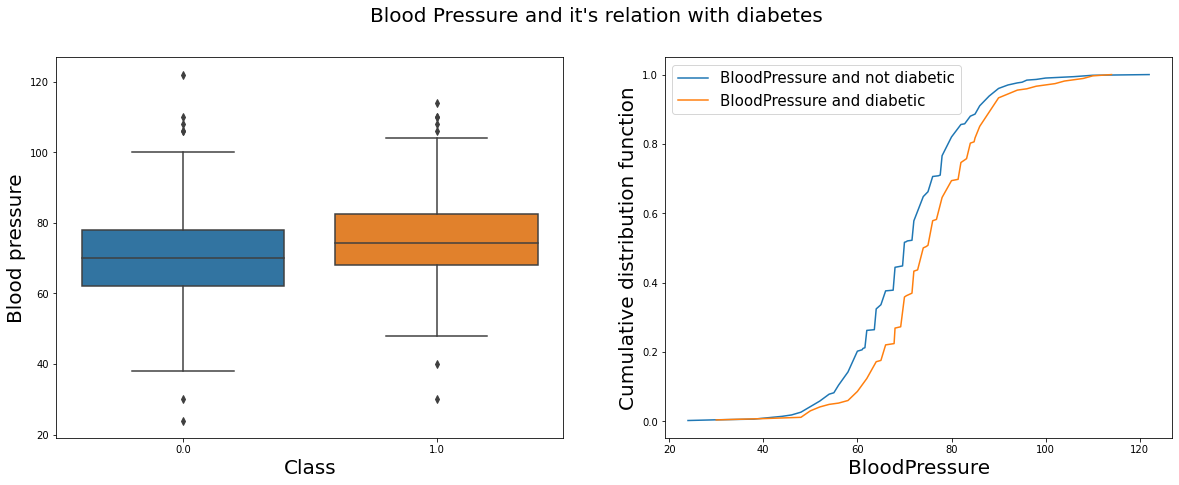

In [ ]:
fig,ax =plt.subplots(1,2, figsize=(15,7))
fig.suptitle("Blood Pressure and it's relation with diabetes", fontsize=20)

plt.subplot(1,2,1)
sns.boxplot(data=newdata, x="Class", y="BP")
plt.ylabel("Blood pressure", fontsize=20)
plt.xlabel("Class", fontsize=20)

plt.subplot(1,2,2)
Cdf.from_seq(notdia["BP"], normalize=True).plot(label= "BloodPressure and not diabetic")
Cdf.from_seq(dia["BP"], normalize=True).plot(label= "BloodPressure and diabetic")
plt.xlabel("BloodPressure", fontsize=20)
plt.ylabel("Cumulative distribution function", fontsize=20)
plt.legend(fontsize=15)
plt.show()

##### As we can observe,***the blue line*** (which refers to not diabetic) to ***the left*** of ***the orange line***(which refers not-diabetic) across the distribution.which shows for every BloodPressure, ***the fraction of diabetic females below that BloodPressure is less than the fraction of not-diabetic below that BloodPressure***. But not by very much.
##### Very few number of femal that's diabetic, with BloodPressure lies from 40 to 60, and there're a few numbers of outliers in this range.

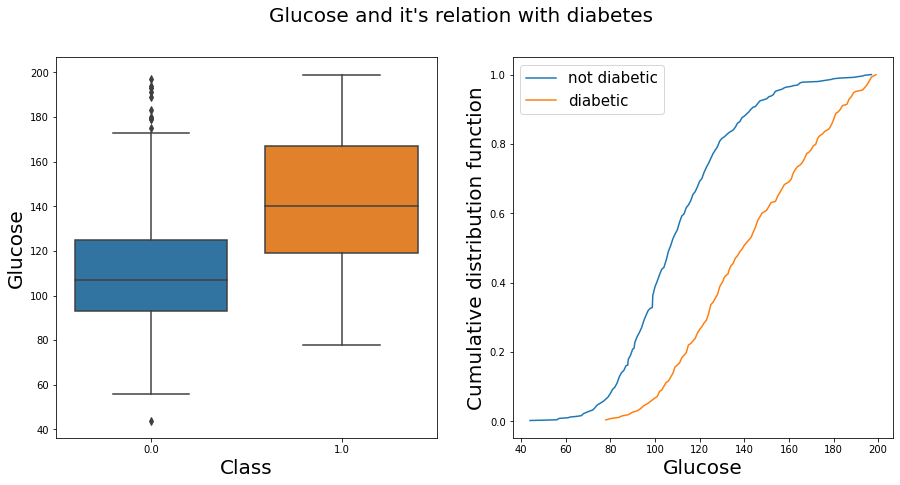

In [ ]:
fig,ax =plt.subplots(1,2, figsize=(15,7))
fig.suptitle("Glucose and it's relation with diabetes", fontsize=20)

plt.subplot(1,2,1)
sns.boxplot(data=newdata, x="Class", y="Glucose")
plt.ylabel("Glucose", fontsize=20)
plt.xlabel("Class", fontsize=20)

plt.subplot(1,2,2)
Cdf.from_seq(notdia["Glucose"], normalize=True).plot(label= "not diabetic")
Cdf.from_seq(dia["Glucose"], normalize=True).plot(label= "diabetic")
plt.xlabel("Glucose", fontsize=20)
plt.ylabel("Cumulative distribution function", fontsize=20)
plt.legend(fontsize=15)
plt.show()

In [ ]:
data.columns

Index(['Pregnant', 'Glucose', 'BP', 'skin', 'insulin', 'BMI', 'DPF', 'Age',
       'Class'],
      dtype='object')

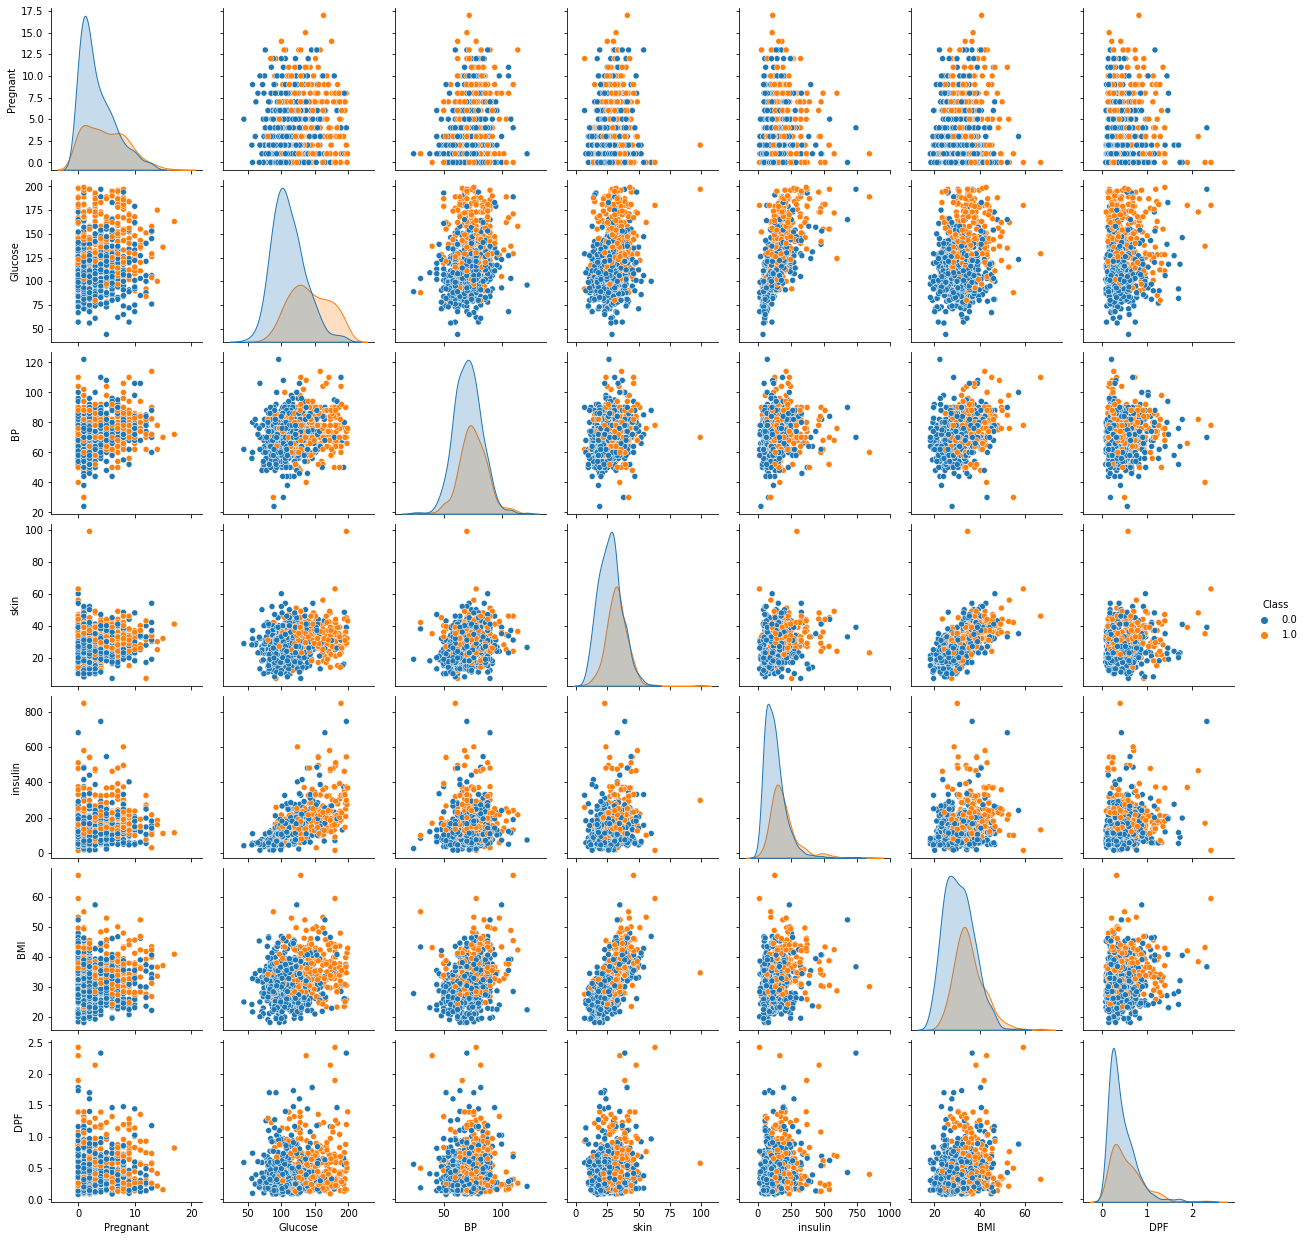

In [ ]:
sns.pairplot(data=newdata, hue="Class", vars=[ 'Glucose', 'skin', 'insulin', 'BMI', 'DPF'])

##### Obviosly the percentage of Glucose and Insulin is the strongest indicators in our dataset. The relationship betteewn Glucose-level and be diabestic is degraded relationship as, the more Glucose-higher-in-level, the more chances for the sample to be diabestic.
##### there are less number of people with high Glucose-level beteewn 150-to-200 they have very higher chances to be diabestic and very less number of people is not-diabestic due to the heigh-level-of-Glucose  
##### Over-Pregnancy-range with high-glucose-level have Diabetes.
##### As BMI increase, and Glucose, there are higher-chances to be diabestic.
##### Middle aged people with high Glucose level and high BloodPressure level have higher chances of Diabetes which is quite intuitive as well.

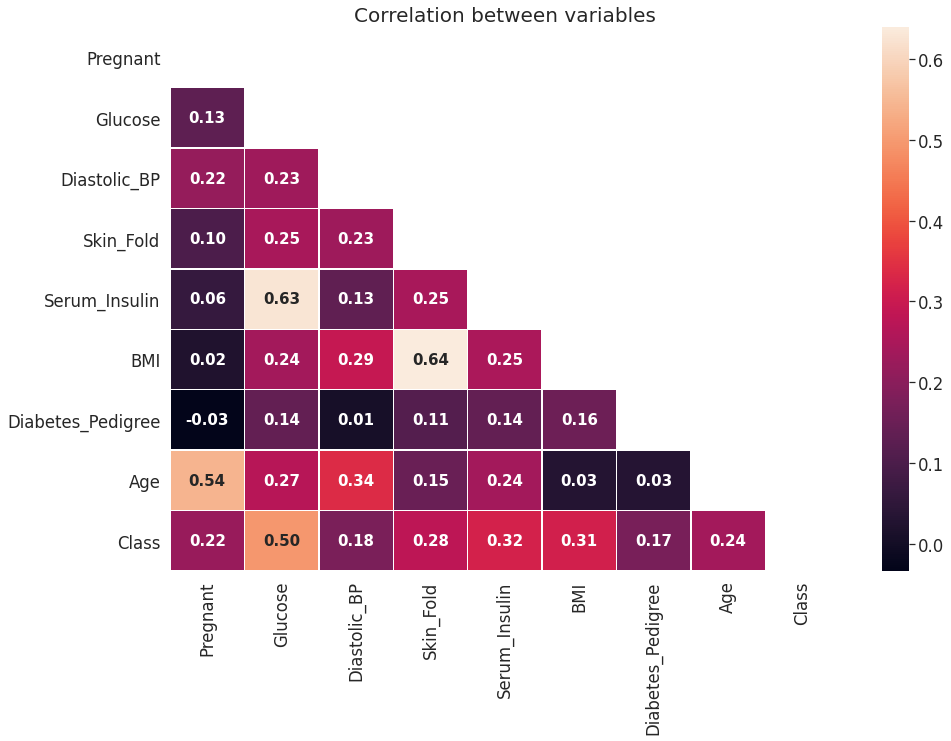

In [ ]:
plt.figure(figsize=(15,10))

plt.title("Correlation between variables", fontsize=20)
corr = newdata.corr()
mask = np.triu(corr)
sns.heatmap(corr, linewidths=0.5, 
            annot=True, mask = mask,
            fmt=".2f", annot_kws={"fontsize":15, "weight":'bold'}).set_facecolor('white')
plt.show()

##### From the correlation matrix we can see that there ***no highly correlated features***, But here are some features that seem to have ***some sort of relationship*** as suggested by the correlation index value around 0.5.
#### Those features are:
##### ***Age - Pregnancies***:  0.54
this is reasonable as the number of pregnancies can only increase as the age increases.
##### ***Glucose - Class***: 0.5
we can deduce that an higher glucose concentration is related to an higher probability of being diagnosed with diabetes. This is also confirmed by the additional information about diabetes reported in the introduction.
##### ***Glucose - Insulin***: 0.63
we can deduce that when there is an higher level of glucose in the blood, the body produces more Insulin.
##### **BMI - Skin**: 0.64
people with an higher Body Mass Index seem to have a thicker skin.

## data preprocessing